# Computer Vision Project

# Project Title:Comparing U-NET and custom CNN performance for 8 Different Cell Types in the LIVECELL Dataset

# Project Members:

# Junaid Haqqani - 23371
# Yousuf Mehmood - 23375

# U-NET Image Segmentation

Initially we tried to replicate the image segmentation of cell images using U-NET as proposed by U-Net: Convolutional Networks for Biomedical
Image Segmentation by Olaf Ronneberger, Philipp Fischer, and Thomas Brox https://arxiv.org/pdf/1505.04597v1.pdf.

Loading essential libraries.

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import cv2
from skimage.transform import resize
from skimage.io import imread, imshow

In [ ]:
RANDOM_STATE = 7
IMG_SHAPE = (520, 704)
POWER = 2
VAL_SIZE = 0.1

np.random.seed(RANDOM_STATE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In order to perform cell segmentation, masks have to be generated for each individual image to enable the network to predict each individual pixel. Mask data for each image is given in the following dataframe.

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/CV project/train.csv')
train_df.head()

id  ... elapsed_timedelta
0  0030fd0e6378  ...   0 days 11:30:00
1  0030fd0e6378  ...   0 days 11:30:00
2  0030fd0e6378  ...   0 days 11:30:00
3  0030fd0e6378  ...   0 days 11:30:00
4  0030fd0e6378  ...   0 days 11:30:00

[5 rows x 9 columns]

Mask data is encoded via Run-Length encoding. Run–length encoding (RLE) is a simple form of lossless data compression that runs on sequences with the same value occurring many consecutive times. It encodes the sequence to store only a single value and its count. In case of cell image, major portion of the image is background with only a small segment of the image has a cell, therefore it is most appropriate to use this compression technique for cell images.

Following functions decode the RLE data into image array and obtain the mask in grey scale and color.

In [ ]:
def rle_decode(mask_rle, shape, color = 1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return 
    color: color for the mask
    Returns numpy array (mask)
    '''
    s = mask_rle.split()
    
    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype = np.float32)
            
    for start, end in zip(starts, ends):
        img[start : end] = color
    
    return img.reshape(shape)

def get_grayscale_mask(image_id, annots):
    grayscale_mask = np.zeros((*IMG_SHAPE, 1))
    
    for annot in annots:
            grayscale_mask += rle_decode(annot, shape = (*IMG_SHAPE, 1))
    
    return grayscale_mask.clip(0, 1)

def get_rgb_mask(image_id, annots):
    rgb_mask = np.zeros((*IMG_SHAPE, 3))
    
    for annot in annots:
        rgb_mask += rle_decode(annot, shape = (*IMG_SHAPE, 3), color = np.random.rand(3))
    
    return rgb_mask.clip(0, 1)

Following function extracts images from the location.

In [ ]:
def get_image(image_id):
    image = cv2.imread(f"/content/drive/MyDrive/CV project/train/{image_id}.png")
    return image.reshape(*IMG_SHAPE, 3)

In [ ]:
def plot_images(image_ids):
    n = len(image_ids)
    grayscale_masks = []
    rgb_masks = []
    images = []
    celltypes = []
    
    for img_id in image_ids:
        row = train_df[train_df["id"] == img_id]

        annots = row["annotation"].tolist()
        celltypes.append(row["cell_type"].tolist()[0])
    
        grayscale_masks.append(get_grayscale_mask(img_id, annots))
        rgb_masks.append(get_rgb_mask(img_id, annots))
        
        images.append(get_image(img_id))
    
    plt.figure(figsize = (20 , 4 * n))
    
    for i in range(n):
        
        plt.subplot(n, 4, (i * 4) + 1)
        plt.imshow(images[i], cmap = 'gray')
        plt.title(f'{image_ids[i]} - {celltypes[i]}', fontsize = 16)
        plt.axis("off")

        plt.subplot(n, 4, (i * 4) + 2)
        plt.imshow(images[i] * grayscale_masks[i], cmap = 'gray')
        plt.title('Input image with mask', fontsize = 16)
        plt.axis("off")

        plt.subplot(n, 4, (i * 4) + 3)
        plt.imshow(rgb_masks[i])
        plt.title('RGB mask', fontsize = 16)
        plt.axis("off")
        
        plt.subplot(n, 4, (i * 4) + 4)
        plt.hist(images[i].flatten(), bins = 255, range = (0, 255))
        plt.title('Pixel distribution', fontsize = 16)
    
    plt.suptitle("Sample images, masks and their pixel distributions", fontsize = 24)
    plt.tight_layout(rect = [0, 0, 0.90, 1])
    plt.show()
    return grayscale_masks, rgb_masks, images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


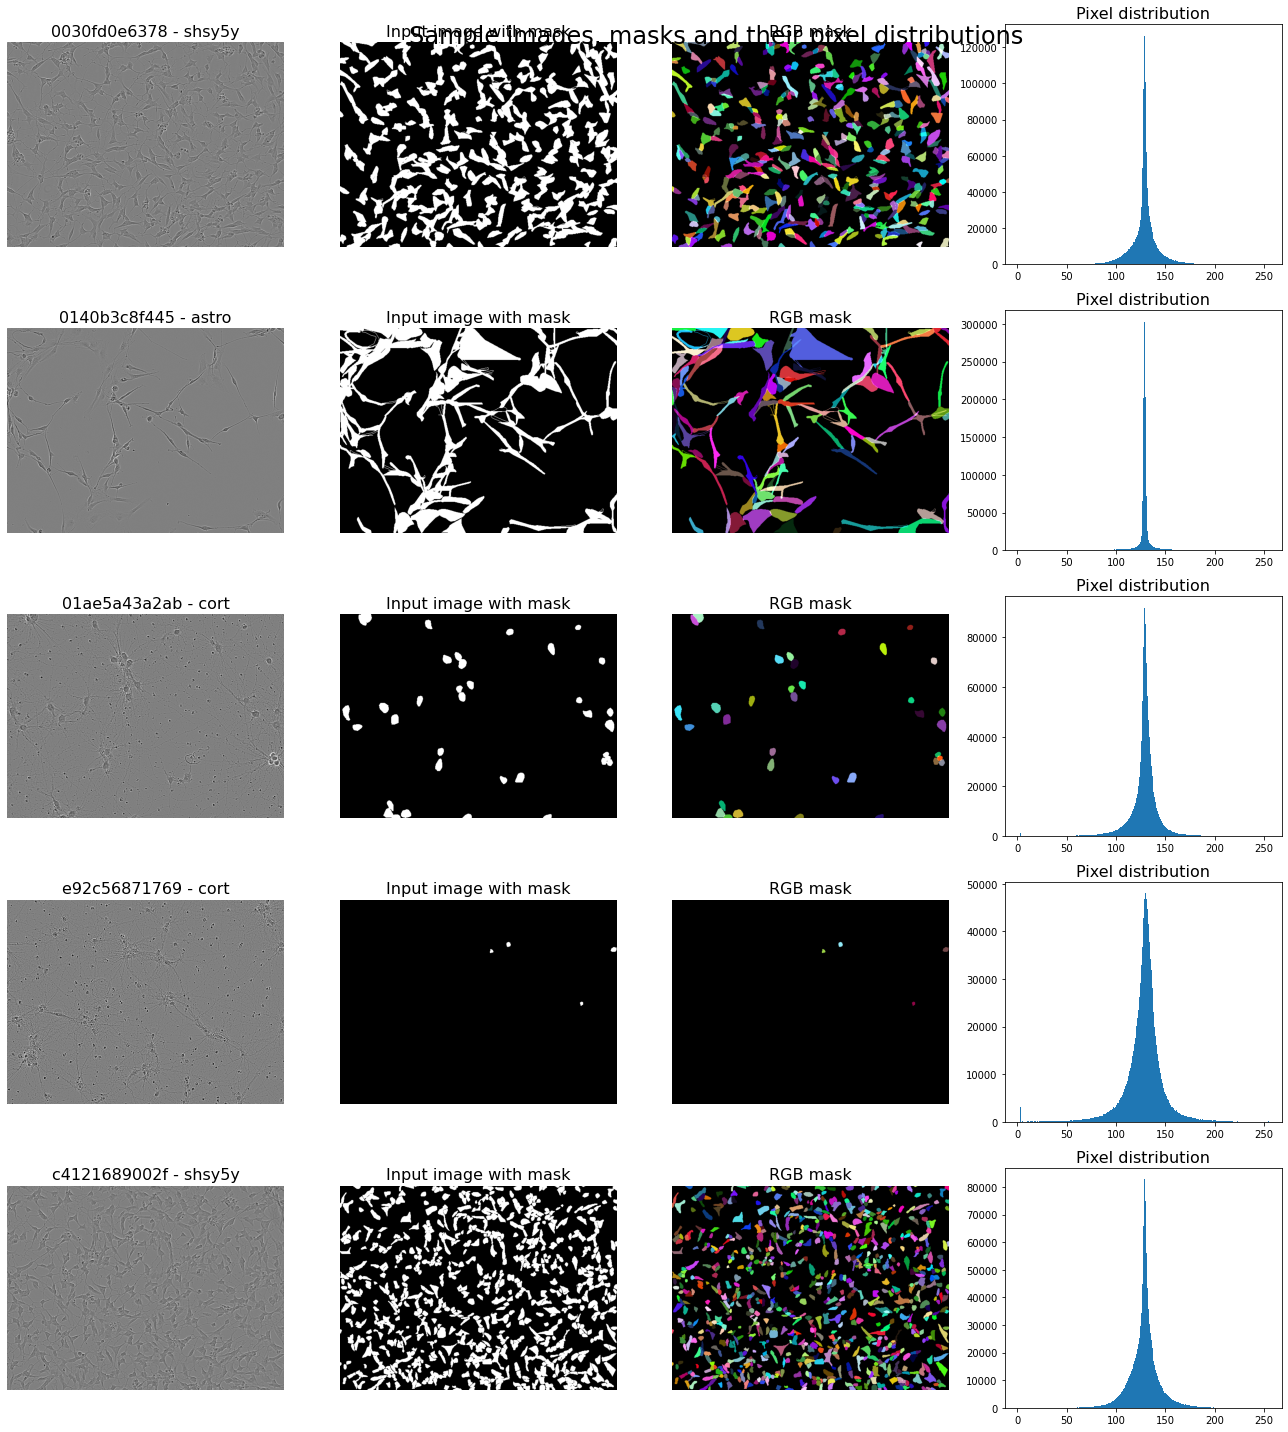

In [ ]:
sample_ids = ['0030fd0e6378','0140b3c8f445','01ae5a43a2ab', 'e92c56871769', 'c4121689002f']
_, _, images = plot_images(sample_ids)


Image transformation


Images have very less contrast as all pixel values are very close together. Pixel values have been updated to rectify that.

Transforming input images¶


In [ ]:
def transform_image(img_data, power = 2):
    img_data_mask = np.ones_like(img_data, dtype = np.int16)
    img_data_mask[img_data < 127.5] = -1
    
    img_data_transformed = img_data.astype(np.int16) - 127.5
    img_data_transformed[img_data_transformed > 0] = np.power(img_data_transformed[img_data_transformed > 0], 1 / power)
    img_data_transformed[img_data_transformed < 0] = np.power(-img_data_transformed[img_data_transformed < 0], 1 / power)
    img_data_transformed = ((img_data_transformed * img_data_mask) / (2 * np.power(127.5, 1 / power))) + 0.5
    
    return img_data_transformed

In [ ]:
def plot_transformed_images(images, transformed_images):
    n = len(images)
    
    plt.figure(figsize = (20 , 4 * n))
    
    for i in range(n):
        plt.subplot(n, 4, (i * 4) + 1)
        plt.imshow(images[i], cmap = 'gray')
        plt.title(f'{sample_ids[i]} - Original', fontsize = 16)
        plt.axis("off")
        
        plt.subplot(n, 4, (i * 4) + 2)
        plt.hist(images[i].flatten() / 255, bins = 255, range = (0, 1))
        plt.title('Original pixel distribution', fontsize = 16)
        
        plt.subplot(n, 4, (i * 4) + 3)
        plt.imshow(transformed_images[i], cmap = 'gray')
        plt.title('Transformed image', fontsize = 16)
        plt.axis("off")
        
        plt.subplot(n, 4, (i * 4) + 4)
        plt.hist(transformed_images[i].flatten(), bins = 255, range = (0, 1))
        plt.title('Pixel distribution after transformation', fontsize = 16)

    plt.suptitle("Image transformation", fontsize = 24)
    plt.tight_layout(rect = [0, 0, 0.90, 1])
    plt.show()

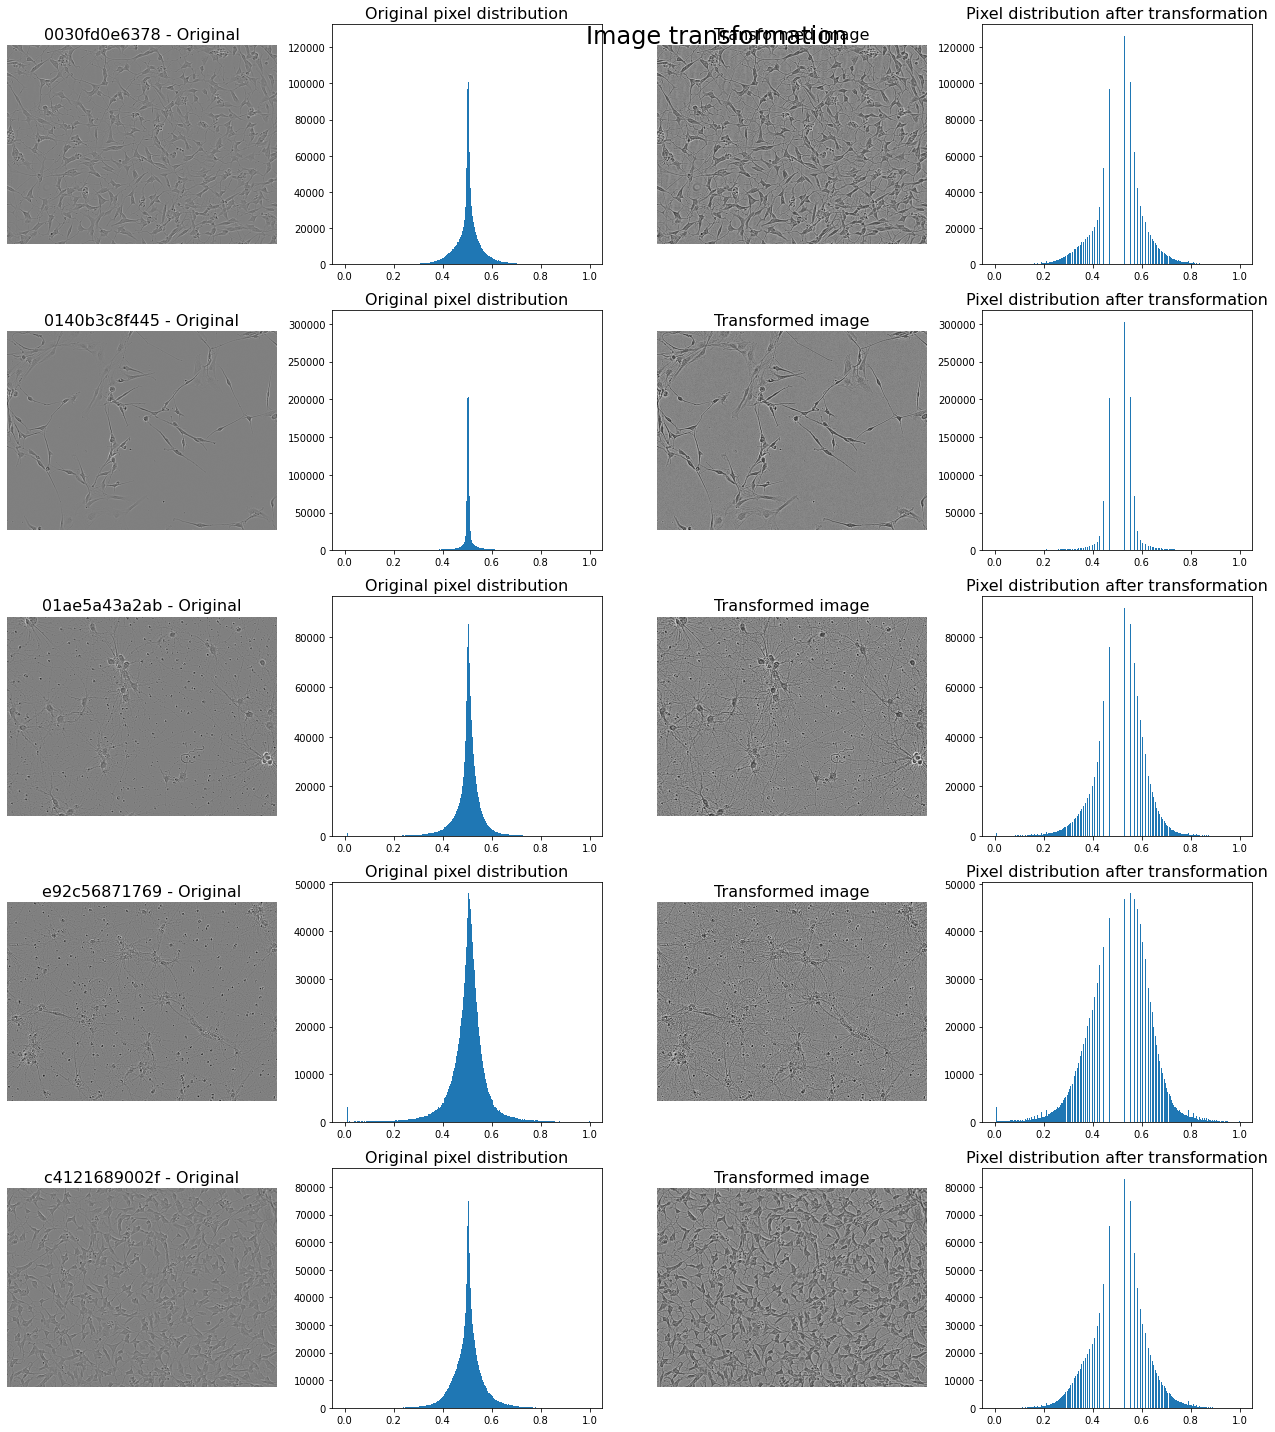

In [ ]:
plot_transformed_images(images, [transform_image(image) for image in images])

Effect of transformation for different values of power¶


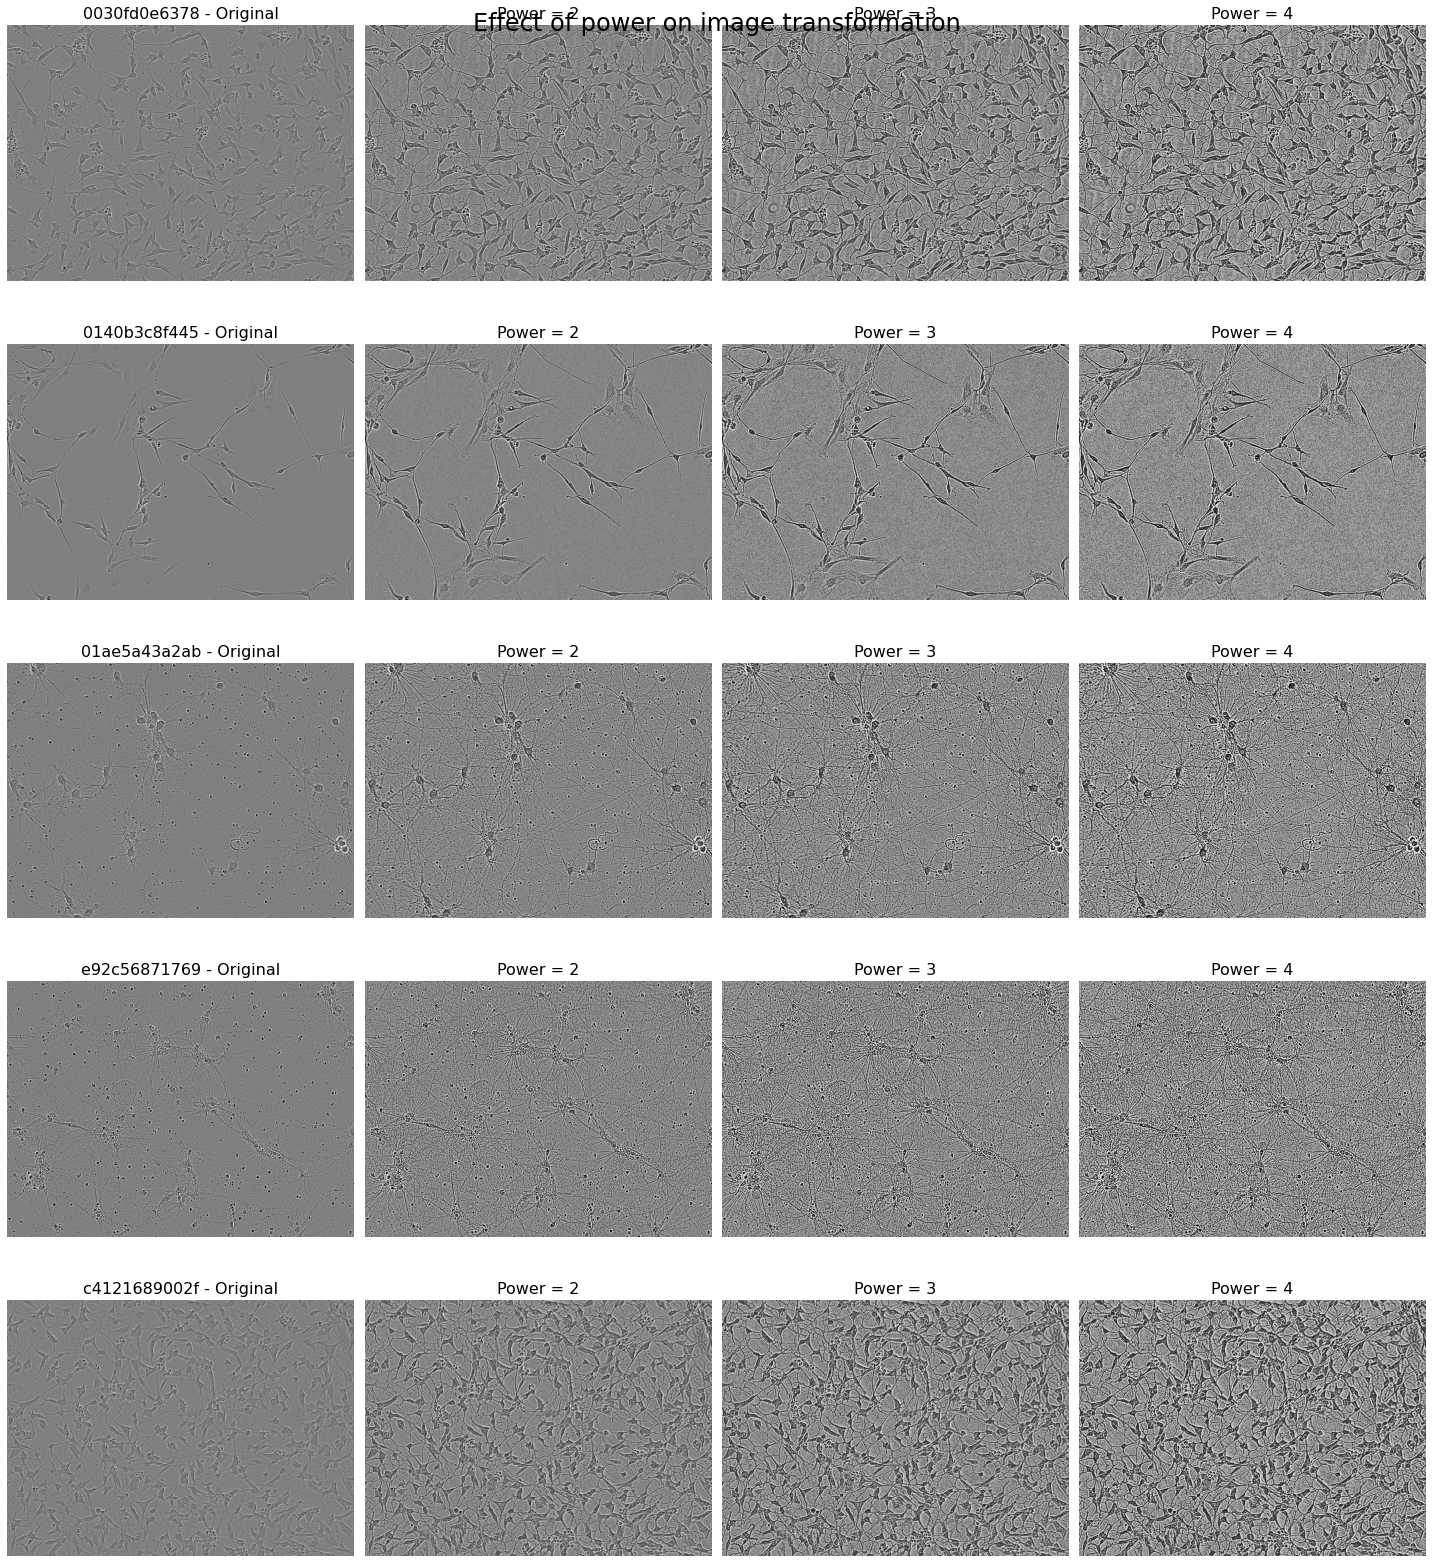

In [ ]:
n = len(images)
plt.figure(figsize = (20 , 4.5 * n))

for i in range(n):
    plt.subplot(n, 4, (i * 4) + 1)
    plt.imshow(images[i], cmap = 'gray')
    plt.title(f'{sample_ids[i]} - Original', fontsize = 16)
    plt.axis("off")
    
    plt.subplot(n, 4, (i * 4) + 2)
    plt.imshow(transform_image(images[i], 2), cmap = 'gray')
    plt.title('Power = 2', fontsize = 16)
    plt.axis("off")
    
    plt.subplot(n, 4, (i * 4) + 3)
    plt.imshow(transform_image(images[i], 3), cmap = 'gray')
    plt.title('Power = 3', fontsize = 16)
    plt.axis("off")
    
    plt.subplot(n, 4, (i * 4) + 4)
    plt.imshow(transform_image(images[i], 4), cmap = 'gray')
    plt.title('Power = 4', fontsize = 16)
    plt.axis("off")
    
plt.suptitle("Effect of power on image transformation", fontsize = 24)
plt.tight_layout()
plt.show()

Power transformations improve the visiblity of cell edges. 

Storing images along with their ids in X and corresponding masks in y.

In [ ]:
X = []
y = []

image_ids = train_df["id"].unique()
np.random.shuffle(image_ids)

for img_id in tqdm(image_ids, unit = " images", desc = "Loading transformed images and their masks in grayscale"):
    image=transform_image(get_image(img_id), POWER)
    new_img = resize(image, (256, 256), mode='constant', preserve_range=True)
    #new_mask = resize(mask, (512, 512), mode='constant', preserve_range=True)
    #X_copy.append(new_img)
    #y_copy.append(new_mask)
    z=[img_id,new_img]
    X.append(z)
    
    annots = train_df[train_df["id"] == img_id]["annotation"].tolist()
    mask=get_grayscale_mask(img_id, annots)
    new_mask = resize(mask, (256, 256), mode='constant', preserve_range=True)
    y.append(new_mask)
X = np.array(X)
y = np.array(y)

X.shape, y.shape

Loading transformed images and their masks in grayscale:   0%|          | 0/606 [00:00<?, ? images/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


((606, 2), (606, 256, 256, 1))

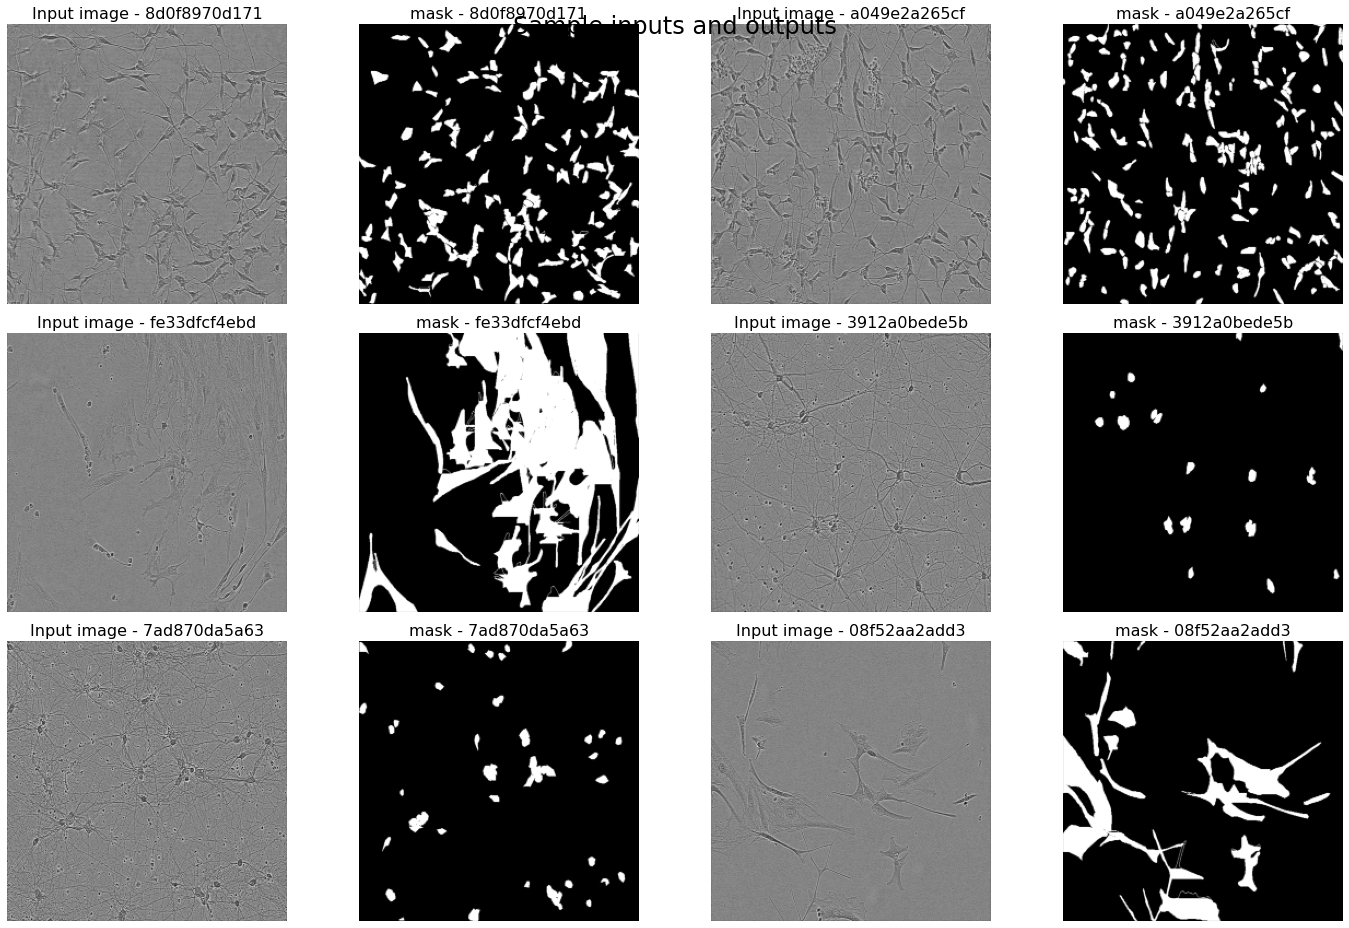

In [ ]:
plt.figure(figsize = (20 , 13))

for i, j in enumerate(np.random.randint(len(image_ids), size = 6)):
    plt.subplot(3, 4, (i * 2) + 1)
    plt.imshow(X[j][1])
    plt.title(f'Input image - {image_ids[j]}', fontsize = 16)
    plt.axis("off")
    
    plt.subplot(3, 4, (i * 2) + 2)
    plt.imshow(y[j][:,:,0], cmap = 'gray')
    plt.title(f'mask - {image_ids[j]}', fontsize = 16)
    plt.axis("off")
    
plt.suptitle("Sample inputs and outputs", fontsize = 24)
plt.tight_layout()
plt.show()

Importing tensorflow and keras for developing the U-NET model.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dropout,MaxPooling2D,concatenate,Conv2DTranspose

In [ ]:
from tensorflow.keras import layers

The UNET was developed by Olaf Ronneberger et al. for Bio Medical Image Segmentation. The architecture contains two paths. First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size. Following is the structure of the UNET:

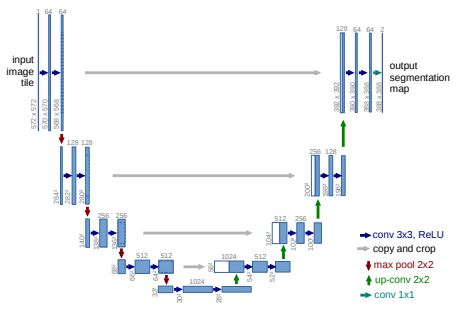

The UNET in the original paper was developed using images of size 512x512, however we have resized our images to 256x256 in order to reduce computational complexity.

The unet architecture has been developed in a seperate python module which has been imported in the proceeding cell.

In [ ]:
import unet

In [ ]:
def get_unet_model():
    return unet.simple_unet_model_with_jacard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3

In [ ]:
unet_model = get_unet_model()




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

Splitting the images into train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split
train_imgs, test_imgs, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sanity check

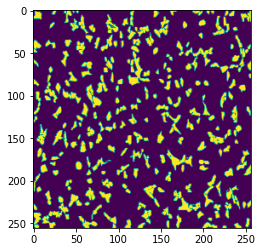

In [ ]:
plt.imshow(y_train[0][:,:,0])

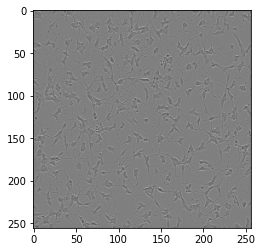

In [ ]:
plt.imshow(train_imgs[0][1])

Seperating the images and ids as X originally contained the image arrays and their corresponding ids. 

In [ ]:
x_train=[]
x_train_id=[]
x_test=[]
x_test_id=[]
for i in tqdm(train_imgs):
  image=i[1]
  id=i[0]
  x_train.append(image)
  x_train_id.append(id)
for i in tqdm(test_imgs):
  image=i[1]
  id=i[0]
  x_test.append(image)
  x_test_id.append(id)
x_train = np.array(x_train)
x_train_id = np.array(x_train_id)
x_test = np.array(x_test)
x_test_id = np.array(x_test_id)

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

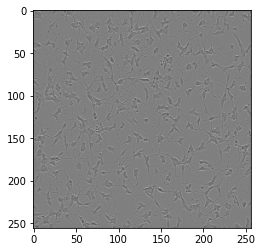

In [ ]:
plt.imshow(x_train[0])

Our goal is to perform semantic segmentation of cells and a specialized loss function is required as accuracy is not a good measure for this case. For this reason we have used the jaccard coefficient as the loss fucntion.

The Jaccard similarity coefficient (Intersection over union) compares members for two sets to see which members are shared and which are distinct. It's a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations

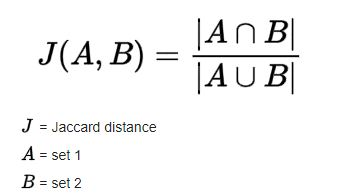

The U-NET model has been trained for 100 epochs with early stopping patience of 35 epochs.

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = "unet-model.h5"

earlystopper = EarlyStopping(patience=35, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = unet_model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=callbacks_list)

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: -0.1068 - jacard_coef: 0.1078
Epoch 00001: val_loss improved from inf to -0.06179, saving model to unet-model.h5
28/28 [==============================] - 14s 424ms/step - loss: -0.1068 - jacard_coef: 0.1078 - val_loss: -0.0618 - val_jacard_coef: 0.0496
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: -0.1071 - jacard_coef: 0.1093
Epoch 00002: val_loss did not improve from -0.06179
28/28 [==============================] - 11s 399ms/step - loss: -0.1071 - jacard_coef: 0.1093 - val_loss: -0.0618 - val_jacard_coef: 0.0496
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: -0.1071 - jacard_coef: 0.1070
Epoch 00003: val_loss did not improve from -0.06179
28/28 [==============================] - 11s 391ms/step - loss: -0.1071 - jacard_coef: 0.1070 - val_loss: -0.0618 - val_jacard_coef: 0.0496
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: -0.1071 - jacard_coef: 0.11

Model performance has been extremely poor.

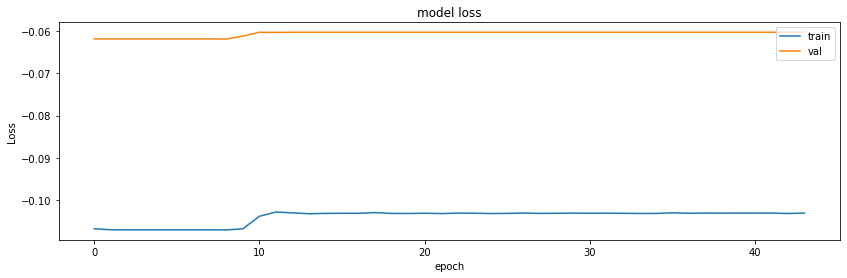

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Image Classification Using Custom CNN

## Importing Relevant Libraries

In [ ]:
from sklearn.metrics import classification_report as crep
from sklearn.model_selection import train_test_split as tts
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization as BN, LeakyReLU as lrelu
from IPython.display import SVG
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import gzip
import pickle
import os, shutil
from tensorflow.keras.optimizers import SGD
from mlxtend.data import loadlocal_mnist
import cv2
from tqdm import tqdm
import random
import numpy as np
import argparse
import time
import os
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

### Setting Standard Image Size to Make CONVOLUTION Easier

In [ ]:
img_size = 128

### Importing LIVECELL Dataset from Desktop Environment

##### The LIVECELL Dataset is over 1 GB in size, hence it's not viable to import it through Google Drive every time. We have imported it through a desktop environment. 

Relevant URL: https://sartorius-research.github.io/LIVECell/

In [ ]:
#Importing Training Set
directory = "E://Computer Vision//Project//images//livecell_train_val_images"
categories = ['A172','BT474','BV2' ,'Huh7' ,'MCF7' ,'SHSY5Y' ,'SkBr3' ,'SKOV3' ]
trainingset = []
for c in categories:
    path = os.path.join(directory,c)
    class_label=categories.index(c)
    for m in os.listdir(path):
            try:
                array2 = cv2.imread(os.path.join(path,m), cv2.IMREAD_GRAYSCALE)
                new_array2 = cv2.resize(array2, (img_size,img_size))
                trainingset.append([new_array2, class_label])
            except Exception as e:
                pass
        
    

In [ ]:
len(trainingset)

3727

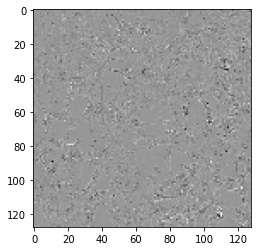

In [ ]:
#Importing one image from the set.
plt.imshow(trainingset[53][0], cmap='gray')
plt.show()

In [ ]:
#Importing Testing Set
directory2 = "E://Computer Vision//Project//images//livecell_test_images"
categories = ['A172','BT474','BV2' ,'Huh7' ,'MCF7' ,'SHSY5Y' ,'SkBr3' ,'SKOV3' ]
testset = []
for c in categories:
    path = os.path.join(directory2,c)
    class_label=categories.index(c)
    for m in os.listdir(path):
            try:
                array2 = cv2.imread(os.path.join(path,m), cv2.IMREAD_GRAYSCALE)
                new_array2 = cv2.resize(array2, (img_size,img_size))
                testset.append([new_array2, class_label])
            except Exception as e:
                pass
    

In [ ]:
len(testset)

1512

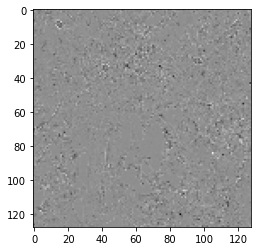

In [ ]:
plt.imshow(testset[53][0], cmap='gray')
plt.show()

### Shuffling Sets to Avoid Bias

In [ ]:
random.shuffle(trainingset)
random.shuffle(testset)

In [ ]:
for i in trainingset:
    print(i[1])

1
6
0
6
5
7
0
1
2
4
6
5
5
4
6
3
4
1
6
1
5
6
1
5
5
6
4
2
5
3
7
6
4
1
5
6
7
7
6
0
7
2
4
6
4
0
7
2
3
4
2
4
0
6
0
3
2
6
2
5
4
3
4
2
4
1
4
7
4
6
5
5
1
5
4
1
1
5
2
6
1
0
4
0
1
5
0
1
6
1
6
5
0
7
4
6
0
7
0
6
2
3
4
2
4
4
2
0
5
1
7
3
1
3
4
4
4
7
3
5
0
3
2
4
0
5
7
6
7
1
4
3
0
6
1
5
6
6
4
2
4
6
5
6
7
6
6
1
1
6
1
4
0
3
5
0
0
5
1
5
6
6
3
4
0
1
6
0
3
2
2
7
0
6
0
3
7
1
0
7
3
1
3
5
4
0
6
4
6
2
1
1
4
0
7
7
3
1
2
3
3
1
0
6
6
6
7
5
2
6
4
3
5
6
6
1
5
0
2
6
5
0
1
5
1
2
6
5
0
5
4
4
4
7
5
1
6
2
5
3
5
1
2
7
4
1
0
4
5
5
3
3
4
6
3
6
4
7
1
4
6
7
4
5
1
6
5
3
4
1
3
3
6
6
6
6
4
6
2
5
5
0
1
7
5
3
2
2
5
0
0
4
5
0
0
2
1
1
6
2
3
6
6
7
2
5
6
5
6
2
7
0
3
3
5
5
0
3
5
4
0
3
0
7
4
4
5
4
3
4
4
5
0
6
2
1
6
4
7
1
5
0
0
2
0
6
3
0
2
4
5
5
4
0
2
4
6
6
5
0
6
1
6
0
2
4
3
4
2
7
1
0
7
5
2
4
5
4
1
3
2
3
1
0
3
2
6
4
3
6
3
5
2
1
6
5
1
3
1
4
5
7
1
3
5
4
7
7
4
6
5
3
3
3
3
2
2
2
3
1
5
0
0
3
4
4
6
3
2
4
1
6
6
0
6
0
0
3
7
3
1
5
5
1
5
4
6
7
2
3
0
6
4
5
0
5
6
0
5
1
1
2
4
0
4
3
1
4
2
6
5
5
4
1
6
1
1
3
2
6
4
1
7
3
5
2
1
6
2
6
7
1
6
0
6
0
6
2
3
4


In [ ]:
for i in testset:
    print(i[1])

0
5
7
3
4
0
2
5
5
5
3
7
3
0
7
7
0
5
5
3
6
7
3
7
4
6
3
4
2
4
5
0
5
6
0
3
7
1
4
7
2
2
0
6
1
7
3
4
2
3
7
5
7
5
5
7
7
1
5
7
5
7
3
6
6
5
7
1
4
6
0
1
1
3
3
7
7
1
6
5
0
1
4
0
2
5
1
2
5
7
3
4
0
3
0
4
5
3
4
0
7
7
0
4
7
3
6
5
1
3
3
5
1
3
3
7
5
0
2
7
3
2
3
1
7
4
2
7
7
7
2
0
7
1
3
4
4
4
1
0
2
6
1
7
7
5
6
2
0
7
3
6
6
7
5
2
0
0
3
0
0
3
7
1
3
0
1
2
5
3
7
5
5
5
7
7
5
3
6
7
7
4
2
0
7
2
4
0
7
7
5
0
6
4
1
7
5
1
5
4
4
0
4
1
7
7
6
2
7
6
7
3
2
3
6
4
4
3
0
0
3
6
6
7
5
0
3
0
5
3
7
4
7
7
2
6
5
6
7
5
0
5
5
7
7
7
3
2
4
3
5
7
4
2
6
4
5
7
2
0
2
7
0
1
0
6
1
6
4
3
5
4
6
7
3
0
7
0
1
3
5
1
0
7
2
1
7
1
4
5
5
6
1
4
4
3
3
4
4
4
2
6
0
7
6
0
4
3
3
4
1
4
2
3
1
7
5
2
3
7
4
0
7
7
2
0
7
3
5
1
7
5
5
0
4
6
6
4
1
1
0
7
3
1
3
3
6
6
7
3
4
7
6
7
7
1
3
0
6
4
7
6
4
6
7
6
7
3
4
0
4
4
3
0
3
3
7
2
7
1
3
0
5
7
4
0
6
7
7
7
6
6
1
1
2
1
6
7
7
7
7
6
6
3
5
7
6
5
0
7
7
3
2
7
7
4
0
7
7
5
3
4
4
4
7
6
7
7
4
3
6
4
7
7
3
7
7
6
2
4
2
6
5
2
2
3
1
0
0
7
5
3
2
7
2
7
4
2
1
4
6
0
7
3
7
6
7
1
7
6
2
5
2
3
6
6
5
0
4
7
5
3
2
6
2
3
5
7
0
3
2
7
1
1
4
2
3
3
7
7


### Dividing the data into features and labels

In [ ]:
#Training Set
X = []
y = []

for features, labels in trainingset:
    X.append(features)
    y.append(labels)


In [ ]:
# Test Set
Xtest = []
ytest = []

for features, labels in testset:
    Xtest.append(features)
    ytest.append(labels)


In [ ]:
len(X), len(y)

(3727, 3727)

In [ ]:
len(Xtest), len(ytest)

(1512, 1512)

In [ ]:
Xtrain = X
ytrain = y

In [ ]:
#reshaping array for feeding into CNN
Xtrain= np.array(Xtrain).reshape(-1,128,128,1)

In [ ]:
Xtrain.shape

(3727, 128, 128, 1)

In [ ]:
#Creating training, testing, and validation set
Xtrain, Xval, ytrain, yval = tts(Xtrain,ytrain,test_size = 0.3, random_state = 42)

In [ ]:
#reshaping array for feeding into CNN
Xtest= np.array(Xtest).reshape(-1,128,128,1)

In [ ]:
Xtest.shape

(1512, 128, 128, 1)

In [ ]:
#Changing data types to float
Xtrain = Xtrain.astype(float)
Xval = Xval.astype(float)
Xtest = Xtest.astype(float)

In [ ]:
#Normalizing features
Xtrain = Xtrain/255.0
Xval = Xval/255.0
Xtest = Xtest/255.0

In [ ]:
#encoding label data
ytrain = to_categorical(ytrain)
yval = to_categorical(yval)
ytest = to_categorical(ytest)

In [ ]:
Xtest,ytest

(array([[[[0.50196078],
          [0.49803922],
          [0.51764706],
          ...,
          [0.50196078],
          [0.50196078],
          [0.50196078]],
 
         [[0.51764706],
          [0.51372549],
          [0.49411765],
          ...,
          [0.50588235],
          [0.50588235],
          [0.50588235]],
 
         [[0.49411765],
          [0.41960784],
          [0.52941176],
          ...,
          [0.50196078],
          [0.50196078],
          [0.50588235]],
 
         ...,
 
         [[0.50980392],
          [0.49803922],
          [0.48627451],
          ...,
          [0.50980392],
          [0.49019608],
          [0.50588235]],
 
         [[0.49411765],
          [0.50588235],
          [0.52156863],
          ...,
          [0.50196078],
          [0.50588235],
          [0.51764706]],
 
         [[0.49411765],
          [0.49411765],
          [0.45490196],
          ...,
          [0.50196078],
          [0.50196078],
          [0.53333333]]],
 
 
        [

In [ ]:
#Saving training and testing sets
pickle_out = open("Xtrain.pickle", "wb")
pickle.dump(Xtrain, pickle_out)
pickle_out.close()

pickle_out = open("Xval.pickle", "wb")
pickle.dump(Xval, pickle_out)
pickle_out.close()

pickle_out = open("Xtest.pickle", "wb")
pickle.dump(Xtest, pickle_out)
pickle_out.close()

pickle_out = open("ytrain.pickle", "wb")
pickle.dump(ytrain, pickle_out)
pickle_out.close()

pickle_out = open("yval.pickle", "wb")
pickle.dump(yval, pickle_out)
pickle_out.close()

pickle_out = open("ytest.pickle", "wb")
pickle.dump(ytest, pickle_out)
pickle_out.close()

In [ ]:
#Importing training and testing sets
pickle_in = open("Xtrain.pickle","rb")
Xtrain = pickle.load(pickle_in)

pickle_in = open("Xval.pickle","rb")
Xval = pickle.load(pickle_in)

pickle_in = open("Xtest.pickle","rb")
Xtest = pickle.load(pickle_in)

pickle_in = open("ytrain.pickle","rb")
ytrain = pickle.load(pickle_in)

pickle_in = open("yval.pickle","rb")
yval = pickle.load(pickle_in)

pickle_in = open("ytest.pickle","rb")
ytest = pickle.load(pickle_in)

## Running CNNs in Different Combinations on Dataset

### Defining CNN Functions

In [ ]:
#Vanilla CNN
def define_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(8, activation='softmax'))
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    return model

#With Batch Normalization
def define_model2(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(8, activation='softmax'))
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    return model

#With Batch Normalization and Dropout Ratio 0.2
def define_model3(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    return model

#With 2 layers
def define_model4(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    return model

#With 3 layers
def define_model5(input_shape):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    return model

#With 4 layers
def define_model6(input_shape):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    return model

#With 5 layers
def define_model7(input_shape):
    model = Sequential()
    model.add(Conv2D(512, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation = 'relu', input_shape=input_shape))
    model.add(BN())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    return model

def evalmodel(modelfit,model,testX, testY):
    plt.subplot(211)
    plt.title('Categorical Cross Entropy Loss')
    plt.plot(modelfit.history['loss'],color = 'green',label='train')
    plt.plot(modelfit.history['val_loss'],color = 'purple', label = 'test')
    plt.legend()
    plt.subplot(212)
    plt.title("Classification Accuracy")
    plt.plot(modelfit.history['accuracy'],color = 'green',label='train')
    plt.plot(modelfit.history['val_accuracy'],color = 'purple', label = 'test')
    plt.legend()
    _, acc,pre,re = model.evaluate(testX, testY, verbose=0)
    print('The accuracy of the model is > %.3f' % (acc * 100.0))
    predictions = model.predict(testX)
    y_test = np.argmax(testY, axis=1)
    y_pred = np.argmax(predictions, axis=1)
    print(crep(y_test,y_pred))


In [ ]:
input_shape = (128,128,1)
num_classes = 8

### Vanilla CNN

In [ ]:
cellmodel1 = define_model(input_shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 127008)            0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1016072   
                                                                 
Total params: 1,016,392
Trainable params: 1,016,392
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fitting model
cellfit1 = cellmodel1.fit(Xtrain, ytrain, epochs = 100, batch_size = 64, validation_data = (Xval, yval))

Epoch 1/100
41/41 [==============================] - 8s 32ms/step - loss: 6.5971 - accuracy: 0.1365 - precision_1: 0.1285 - recall_1: 0.0567 - val_loss: 2.0471 - val_accuracy: 0.1215 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/100
41/41 [==============================] - 1s 19ms/step - loss: 2.0227 - accuracy: 0.1231 - precision_1: 1.0000 - recall_1: 0.0092 - val_loss: 2.0054 - val_accuracy: 0.1215 - val_precision_1: 1.0000 - val_recall_1: 0.0179
Epoch 3/100
41/41 [==============================] - 1s 19ms/step - loss: 1.9831 - accuracy: 0.1227 - precision_1: 1.0000 - recall_1: 0.0265 - val_loss: 1.9734 - val_accuracy: 0.1215 - val_precision_1: 1.0000 - val_recall_1: 0.0331
Epoch 4/100
41/41 [==============================] - 1s 19ms/step - loss: 1.9544 - accuracy: 0.1212 - precision_1: 1.0000 - recall_1: 0.0349 - val_loss: 1.9534 - val_accuracy: 0.1180 - val_precision_1: 1.0000 - val_recall_1: 0.0349
Epoch 5/100
41/41 [==============================] - 1s 19ms/ste

41/41 [==============================] - 1s 20ms/step - loss: 0.7282 - accuracy: 0.8646 - precision_1: 0.9936 - recall_1: 0.5360 - val_loss: 1.2862 - val_accuracy: 0.5514 - val_precision_1: 0.8316 - val_recall_1: 0.2913
Epoch 72/100
41/41 [==============================] - 1s 20ms/step - loss: 0.7146 - accuracy: 0.8892 - precision_1: 0.9929 - recall_1: 0.5395 - val_loss: 1.1216 - val_accuracy: 0.6622 - val_precision_1: 0.8747 - val_recall_1: 0.2806
Epoch 73/100
41/41 [==============================] - 1s 20ms/step - loss: 0.6948 - accuracy: 0.8869 - precision_1: 0.9953 - recall_1: 0.5706 - val_loss: 1.1659 - val_accuracy: 0.5836 - val_precision_1: 0.8988 - val_recall_1: 0.3414
Epoch 74/100
41/41 [==============================] - 1s 20ms/step - loss: 0.6695 - accuracy: 0.9011 - precision_1: 0.9961 - recall_1: 0.5859 - val_loss: 1.0957 - val_accuracy: 0.6542 - val_precision_1: 0.9134 - val_recall_1: 0.3298
Epoch 75/100
41/41 [==============================] - 1s 20ms/step - loss: 0.6546

The accuracy of the model is > 26.587
              precision    recall  f1-score   support

           0       0.29      0.61      0.39       152
           1       0.10      0.12      0.11       168
           2       0.37      0.25      0.30       152
           3       0.54      0.44      0.48       200
           4       0.20      0.10      0.14       184
           5       0.13      0.22      0.16       176
           6       0.39      0.31      0.35       176
           7       0.28      0.16      0.21       304

    accuracy                           0.27      1512
   macro avg       0.29      0.28      0.27      1512
weighted avg       0.29      0.27      0.26      1512



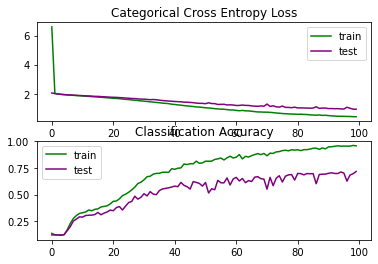

In [ ]:
#evaluating model
evalmodel(cellfit1, cellmodel1,Xtest,ytest)

In [ ]:
#Saving model
cellmodel1.save('cellmodel1.h5')

### With Batch Normalization

In [ ]:
cellmodel2 = define_model2(input_shape)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 batch_normalization_1 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 127008)            0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1016072   
                                                                 
Total params: 1,016,520
Trainable params: 1,016,456
No

In [ ]:
#Fitting model
cellfit2 = cellmodel2.fit(Xtrain, ytrain, epochs = 100, batch_size = 64, validation_data = (Xval, yval))

Epoch 1/100
41/41 [==============================] - 2s 34ms/step - loss: 2.8914 - accuracy: 0.4053 - precision_3: 0.4849 - recall_3: 0.3443 - val_loss: 3.2404 - val_accuracy: 0.1609 - val_precision_3: 0.2543 - val_recall_3: 0.1448
Epoch 2/100
41/41 [==============================] - 1s 27ms/step - loss: 0.2736 - accuracy: 0.9252 - precision_3: 0.9536 - recall_3: 0.8903 - val_loss: 2.9830 - val_accuracy: 0.2100 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0672 - accuracy: 0.9954 - precision_3: 0.9962 - recall_3: 0.9927 - val_loss: 2.4838 - val_accuracy: 0.2172 - val_precision_3: 0.4425 - val_recall_3: 0.0447
Epoch 4/100
41/41 [==============================] - 1s 26ms/step - loss: 0.0375 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 2.0970 - val_accuracy: 0.1895 - val_precision_3: 0.7204 - val_recall_3: 0.0599
Epoch 5/100
41/41 [==============================] - 1s 27ms/ste

41/41 [==============================] - 1s 27ms/step - loss: 0.0013 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 0.7847 - val_accuracy: 0.7811 - val_precision_3: 0.7974 - val_recall_3: 0.7632
Epoch 72/100
41/41 [==============================] - 1s 28ms/step - loss: 0.0013 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 0.7854 - val_accuracy: 0.7828 - val_precision_3: 0.7989 - val_recall_3: 0.7632
Epoch 73/100
41/41 [==============================] - 1s 27ms/step - loss: 0.0013 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 0.7835 - val_accuracy: 0.7819 - val_precision_3: 0.7981 - val_recall_3: 0.7632
Epoch 74/100
41/41 [==============================] - 1s 28ms/step - loss: 0.0013 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 0.7865 - val_accuracy: 0.7793 - val_precision_3: 0.7979 - val_recall_3: 0.7623
Epoch 75/100
41/41 [==============================] - 1s 27ms/step - loss: 0.0012

The accuracy of the model is > 31.878
              precision    recall  f1-score   support

           0       0.33      0.65      0.44       152
           1       0.09      0.11      0.10       168
           2       0.56      0.65      0.60       152
           3       0.57      0.40      0.47       200
           4       0.23      0.11      0.15       184
           5       0.15      0.23      0.18       176
           6       0.52      0.36      0.43       176
           7       0.30      0.20      0.24       304

    accuracy                           0.32      1512
   macro avg       0.34      0.34      0.33      1512
weighted avg       0.34      0.32      0.32      1512



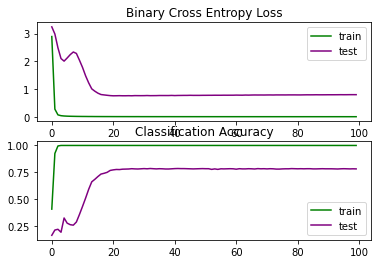

In [ ]:
#evaluating model
evalmodel(cellfit2, cellmodel2,Xtest,ytest)

In [ ]:
#Saving model
cellmodel2.save('cellmodel2.h5')

### With Batch Normalization and Dropout

In [ ]:
cellmodel3 = define_model3(input_shape)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 batch_normalization_2 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 127008)            0         
                                                                 
 dropout (Dropout)           (None, 127008)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                

In [ ]:
#Fitting model
cellfit3 = cellmodel3.fit(Xtrain, ytrain, epochs = 100, batch_size = 64, validation_data = (Xval, yval))

Epoch 1/100
41/41 [==============================] - 2s 40ms/step - loss: 2.7604 - accuracy: 0.3988 - precision_4: 0.4711 - recall_4: 0.3470 - val_loss: 4.1219 - val_accuracy: 0.1260 - val_precision_4: 0.1256 - val_recall_4: 0.1251
Epoch 2/100
41/41 [==============================] - 1s 28ms/step - loss: 0.3920 - accuracy: 0.8877 - precision_4: 0.9194 - recall_4: 0.8528 - val_loss: 3.2978 - val_accuracy: 0.1135 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/100
41/41 [==============================] - 1s 29ms/step - loss: 0.1035 - accuracy: 0.9816 - precision_4: 0.9875 - recall_4: 0.9728 - val_loss: 2.9285 - val_accuracy: 0.1403 - val_precision_4: 0.0714 - val_recall_4: 0.0027
Epoch 4/100
41/41 [==============================] - 1s 29ms/step - loss: 0.0395 - accuracy: 0.9988 - precision_4: 0.9988 - recall_4: 0.9988 - val_loss: 2.5372 - val_accuracy: 0.1394 - val_precision_4: 0.1429 - val_recall_4: 0.0054
Epoch 5/100
41/41 [==============================] - 1s 28ms/ste

41/41 [==============================] - 1s 29ms/step - loss: 0.0012 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 0.8197 - val_accuracy: 0.7730 - val_precision_4: 0.8017 - val_recall_4: 0.7516
Epoch 72/100
41/41 [==============================] - 1s 30ms/step - loss: 0.0012 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 0.8167 - val_accuracy: 0.7721 - val_precision_4: 0.8008 - val_recall_4: 0.7507
Epoch 73/100
41/41 [==============================] - 1s 29ms/step - loss: 0.0012 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 0.8187 - val_accuracy: 0.7721 - val_precision_4: 0.7979 - val_recall_4: 0.7516
Epoch 74/100
41/41 [==============================] - 1s 29ms/step - loss: 0.0013 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 0.8233 - val_accuracy: 0.7694 - val_precision_4: 0.7994 - val_recall_4: 0.7516
Epoch 75/100
41/41 [==============================] - 1s 29ms/step - loss: 0.0011

The accuracy of the model is > 30.225
              precision    recall  f1-score   support

           0       0.33      0.66      0.44       152
           1       0.11      0.13      0.12       168
           2       0.46      0.68      0.55       152
           3       0.48      0.24      0.32       200
           4       0.25      0.14      0.18       184
           5       0.20      0.28      0.23       176
           6       0.47      0.30      0.37       176
           7       0.26      0.18      0.21       304

    accuracy                           0.30      1512
   macro avg       0.32      0.33      0.30      1512
weighted avg       0.32      0.30      0.29      1512



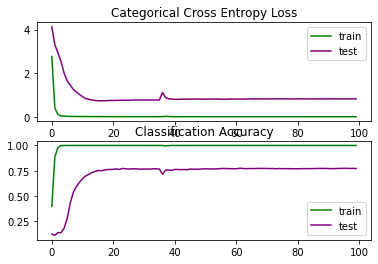

In [ ]:
#evaluating model
evalmodel(cellfit3, cellmodel3,Xtest,ytest)

In [ ]:
#Saving model
cellmodel3.save('cellmodel3.h5')

### With 2 Layers + Batch Normalization + Dropout

In [ ]:
cellmodel4 = define_model4(input_shape)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 64)      640       
                                                                 
 batch_normalization_3 (Batc  (None, 126, 126, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 batch_normalization_4 (Batc  (None, 61, 61, 32)       128       
 hNormalization)                                                 
                                                      

In [ ]:
#Fitting model
cellfit4 = cellmodel4.fit(Xtrain, ytrain, epochs = 100, batch_size = 64, validation_data = (Xval, yval))

Epoch 1/100
41/41 [==============================] - 4s 74ms/step - loss: 2.3644 - accuracy: 0.4586 - precision_5: 0.5185 - recall_5: 0.4187 - val_loss: 5.5891 - val_accuracy: 0.1573 - val_precision_5: 0.1573 - val_recall_5: 0.1573
Epoch 2/100
41/41 [==============================] - 2s 55ms/step - loss: 0.3829 - accuracy: 0.8788 - precision_5: 0.8979 - recall_5: 0.8666 - val_loss: 2.7748 - val_accuracy: 0.1573 - val_precision_5: 0.1597 - val_recall_5: 0.1573
Epoch 3/100
41/41 [==============================] - 2s 55ms/step - loss: 0.1296 - accuracy: 0.9663 - precision_5: 0.9732 - recall_5: 0.9601 - val_loss: 1.9193 - val_accuracy: 0.2672 - val_precision_5: 0.5362 - val_recall_5: 0.1323
Epoch 4/100
41/41 [==============================] - 2s 56ms/step - loss: 0.0597 - accuracy: 0.9900 - precision_5: 0.9919 - recall_5: 0.9873 - val_loss: 2.2980 - val_accuracy: 0.2198 - val_precision_5: 0.2497 - val_recall_5: 0.1761
Epoch 5/100
41/41 [==============================] - 2s 56ms/step - loss

41/41 [==============================] - 2s 58ms/step - loss: 0.0022 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - val_loss: 0.7611 - val_accuracy: 0.8070 - val_precision_5: 0.8241 - val_recall_5: 0.7954
Epoch 37/100
41/41 [==============================] - 2s 58ms/step - loss: 0.0021 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - val_loss: 0.7913 - val_accuracy: 0.7962 - val_precision_5: 0.8152 - val_recall_5: 0.7882
Epoch 38/100
41/41 [==============================] - 2s 58ms/step - loss: 0.0017 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - val_loss: 0.7519 - val_accuracy: 0.8088 - val_precision_5: 0.8232 - val_recall_5: 0.7989
Epoch 39/100
41/41 [==============================] - 2s 58ms/step - loss: 0.0018 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - val_loss: 0.7266 - val_accuracy: 0.8186 - val_precision_5: 0.8367 - val_recall_5: 0.8061s: 0.0020 - accuracy: 1.0000 - precision_5: 1.0000 - 
Epoch 40/100
41/41 [========

41/41 [==============================] - 2s 60ms/step - loss: 7.3178e-04 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - val_loss: 0.7632 - val_accuracy: 0.8239 - val_precision_5: 0.8387 - val_recall_5: 0.8088
Epoch 99/100
41/41 [==============================] - 2s 59ms/step - loss: 6.3672e-04 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - val_loss: 0.7502 - val_accuracy: 0.8239 - val_precision_5: 0.8341 - val_recall_5: 0.8088
Epoch 100/100
41/41 [==============================] - 2s 59ms/step - loss: 9.0478e-04 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - val_loss: 0.9530 - val_accuracy: 0.7837 - val_precision_5: 0.7943 - val_recall_5: 0.7730


The accuracy of the model is > 32.407
              precision    recall  f1-score   support

           0       0.23      0.71      0.35       152
           1       0.14      0.13      0.13       168
           2       0.77      0.53      0.62       152
           3       0.56      0.14      0.23       200
           4       0.52      0.16      0.24       184
           5       0.23      0.43      0.30       176
           6       0.61      0.51      0.55       176
           7       0.30      0.19      0.23       304

    accuracy                           0.32      1512
   macro avg       0.42      0.35      0.33      1512
weighted avg       0.41      0.32      0.32      1512



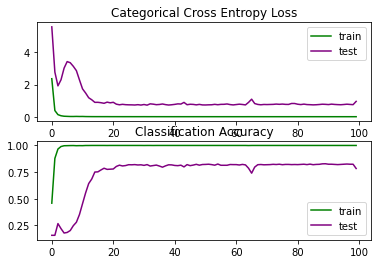

In [ ]:
#evaluating model
evalmodel(cellfit4, cellmodel4,Xtest,ytest)

In [ ]:
#Saving model
cellmodel4.save('cellmodel4.h5')

### With 3 Layers + Batch Normalization + Dropout

In [ ]:
cellmodel5 = define_model5(input_shape)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 126, 126, 128)     1280      
                                                                 
 batch_normalization_5 (Batc  (None, 126, 126, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 63, 63, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 batch_normalization_6 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
#Fitting model, reducing number of epochs and batch size. Research has indicated more complex models tend to converge
#faster and can do with smaller batch sizes as training parameters decrease. 
cellfit5 = cellmodel5.fit(Xtrain, ytrain, epochs = 60, batch_size = 32, validation_data = (Xval, yval))

Epoch 1/60
82/82 [==============================] - 7s 68ms/step - loss: 1.9595 - accuracy: 0.4739 - precision_6: 0.5510 - recall_6: 0.4041 - val_loss: 3.0854 - val_accuracy: 0.1761 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/60
82/82 [==============================] - 5s 57ms/step - loss: 0.5409 - accuracy: 0.8098 - precision_6: 0.8532 - recall_6: 0.7642 - val_loss: 5.2682 - val_accuracy: 0.1126 - val_precision_6: 0.1120 - val_recall_6: 0.1117
Epoch 3/60
82/82 [==============================] - 5s 58ms/step - loss: 0.3142 - accuracy: 0.8969 - precision_6: 0.9181 - recall_6: 0.8731 - val_loss: 6.8611 - val_accuracy: 0.1144 - val_precision_6: 0.1151 - val_recall_6: 0.1144
Epoch 4/60
82/82 [==============================] - 5s 58ms/step - loss: 0.2086 - accuracy: 0.9314 - precision_6: 0.9484 - recall_6: 0.9160 - val_loss: 7.2913 - val_accuracy: 0.1421 - val_precision_6: 0.1422 - val_recall_6: 0.1412
Epoch 5/60
82/82 [==============================] - 5s 58ms/step - l

82/82 [==============================] - 5s 60ms/step - loss: 0.0024 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 0.5237 - val_accuracy: 0.8597 - val_precision_6: 0.8661 - val_recall_6: 0.8552
Epoch 58/60
82/82 [==============================] - 5s 61ms/step - loss: 0.0020 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 0.5088 - val_accuracy: 0.8686 - val_precision_6: 0.8745 - val_recall_6: 0.8597
Epoch 59/60
82/82 [==============================] - 5s 60ms/step - loss: 0.0020 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 0.5090 - val_accuracy: 0.8651 - val_precision_6: 0.8715 - val_recall_6: 0.8606
Epoch 60/60
82/82 [==============================] - 5s 60ms/step - loss: 0.0018 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 0.5015 - val_accuracy: 0.8677 - val_precision_6: 0.8749 - val_recall_6: 0.8624


The accuracy of the model is > 52.844
              precision    recall  f1-score   support

           0       0.42      0.68      0.52       152
           1       0.23      0.22      0.22       168
           2       0.74      0.84      0.79       152
           3       0.60      0.36      0.45       200
           4       0.50      0.28      0.36       184
           5       0.33      0.40      0.36       176
           6       0.94      0.85      0.90       176
           7       0.56      0.61      0.59       304

    accuracy                           0.53      1512
   macro avg       0.54      0.53      0.52      1512
weighted avg       0.54      0.53      0.52      1512



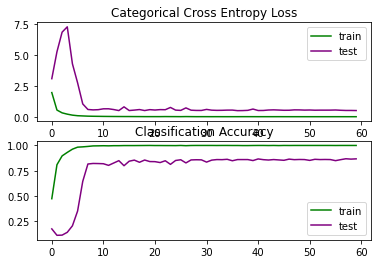

In [ ]:
#evaluating model
evalmodel(cellfit5, cellmodel5,Xtest,ytest)

In [ ]:
#Saving model
cellmodel5.save('cellmodel5.h5')

### Significant Jump in Accuracy
For the first time in this process, we've seen a significant jump in overall accuracy while it was dwelling in the early 30s in previous attempts. 

Significantly better accuracy has been achieved in classifying cell types 1, 7, and 8

## With 4 Layers + Batch Normalization + Dropout

In [ ]:
cellmodel6 = define_model6(input_shape)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 126, 256)     2560      
                                                                 
 batch_normalization_8 (Batc  (None, 126, 126, 256)    1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 63, 63, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 128)       295040    
                                                                 
 batch_normalization_9 (Batc  (None, 61, 61, 128)      512       
 hNormalization)                                                 
                                                      

In [ ]:
#Reducing epochs to 50, and batch size to 32
cellfit6 = cellmodel6.fit(Xtrain, ytrain, epochs = 50, batch_size = 16, validation_data = (Xval, yval))

Epoch 1/50
163/163 [==============================] - 13s 68ms/step - loss: 1.6907 - accuracy: 0.4812 - precision_7: 0.5459 - recall_7: 0.3900 - val_loss: 5.9979 - val_accuracy: 0.1171 - val_precision_7: 0.1482 - val_recall_7: 0.0992
Epoch 2/50
163/163 [==============================] - 10s 63ms/step - loss: 0.7425 - accuracy: 0.7347 - precision_7: 0.7848 - recall_7: 0.6699 - val_loss: 9.9129 - val_accuracy: 0.1010 - val_precision_7: 0.1049 - val_recall_7: 0.1010
Epoch 3/50
163/163 [==============================] - 10s 63ms/step - loss: 0.4746 - accuracy: 0.8248 - precision_7: 0.8553 - recall_7: 0.7929 - val_loss: 4.4612 - val_accuracy: 0.1859 - val_precision_7: 0.1972 - val_recall_7: 0.1743
Epoch 4/50
163/163 [==============================] - 10s 64ms/step - loss: 0.3038 - accuracy: 0.8969 - precision_7: 0.9167 - recall_7: 0.8738 - val_loss: 0.7822 - val_accuracy: 0.7158 - val_precision_7: 0.7530 - val_recall_7: 0.6729
Epoch 5/50
163/163 [==============================] - 11s 66ms/s

Epoch 36/50
163/163 [==============================] - 11s 66ms/step - loss: 0.0071 - accuracy: 0.9988 - precision_7: 0.9988 - recall_7: 0.9988 - val_loss: 0.2862 - val_accuracy: 0.9366 - val_precision_7: 0.9449 - val_recall_7: 0.9348
Epoch 37/50
163/163 [==============================] - 11s 66ms/step - loss: 0.0081 - accuracy: 0.9985 - precision_7: 0.9985 - recall_7: 0.9985 - val_loss: 0.2368 - val_accuracy: 0.9348 - val_precision_7: 0.9380 - val_recall_7: 0.9330
Epoch 38/50
163/163 [==============================] - 11s 66ms/step - loss: 0.0063 - accuracy: 0.9992 - precision_7: 0.9992 - recall_7: 0.9992 - val_loss: 0.2649 - val_accuracy: 0.9366 - val_precision_7: 0.9406 - val_recall_7: 0.9339
Epoch 39/50
163/163 [==============================] - 11s 66ms/step - loss: 0.0093 - accuracy: 0.9977 - precision_7: 0.9977 - recall_7: 0.9977 - val_loss: 0.5482 - val_accuracy: 0.8686 - val_precision_7: 0.8732 - val_recall_7: 0.8615
Epoch 40/50
163/163 [==============================] - 11s 6

The accuracy of the model is > 74.140
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       152
           1       0.87      0.64      0.74       168
           2       0.86      0.95      0.91       152
           3       0.86      0.41      0.55       200
           4       0.85      0.46      0.59       184
           5       0.59      0.82      0.69       176
           6       0.87      0.99      0.93       176
           7       0.68      0.89      0.77       304

    accuracy                           0.74      1512
   macro avg       0.78      0.74      0.73      1512
weighted avg       0.77      0.74      0.73      1512



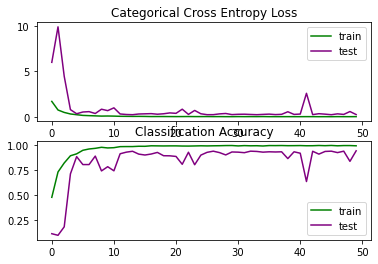

In [ ]:
evalmodel(cellfit6, cellmodel6,Xtest,ytest)

In [ ]:
#Saving model
cellmodel6.save('cellmodel6.h5')

### Another Massive Jump in Accuracy
Adding another layer to the CNN resulted in another massive jump in classification accuracy.

## With 5 Layers + Batch Normalization + Dropout

In [ ]:
cellmodel7 = define_model7(input_shape)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 126, 126, 512)     5120      
                                                                 
 batch_normalization_12 (Bat  (None, 126, 126, 512)    2048      
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 63, 63, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 61, 61, 256)       1179904   
                                                                 
 batch_normalization_13 (Bat  (None, 61, 61, 256)      1024      
 chNormalization)                                                
                                                      

In [ ]:
#Reducing epochs to 50, and batch size to 32
cellfit7 = cellmodel7.fit(Xtrain, ytrain, epochs = 50, batch_size = 16, validation_data = (Xval, yval))

Epoch 1/50
163/163 [==============================] - 28s 151ms/step - loss: 1.6716 - accuracy: 0.4402 - precision_8: 0.5341 - recall_8: 0.3094 - val_loss: 4.0648 - val_accuracy: 0.1662 - val_precision_8: 0.1289 - val_recall_8: 0.0331
Epoch 2/50
163/163 [==============================] - 23s 142ms/step - loss: 0.9520 - accuracy: 0.6564 - precision_8: 0.7621 - recall_8: 0.5418 - val_loss: 4.7462 - val_accuracy: 0.1734 - val_precision_8: 0.1561 - val_recall_8: 0.0420
Epoch 3/50
163/163 [==============================] - 24s 147ms/step - loss: 0.6502 - accuracy: 0.7795 - precision_8: 0.8518 - recall_8: 0.7032 - val_loss: 3.1324 - val_accuracy: 0.2100 - val_precision_8: 0.2141 - val_recall_8: 0.1707
Epoch 4/50
163/163 [==============================] - 24s 148ms/step - loss: 0.4570 - accuracy: 0.8397 - precision_8: 0.8868 - recall_8: 0.7964 - val_loss: 0.9877 - val_accuracy: 0.6568 - val_precision_8: 0.7460 - val_recall_8: 0.5853
Epoch 5/50
163/163 [==============================] - 24s 14

Epoch 36/50
163/163 [==============================] - 24s 147ms/step - loss: 0.0089 - accuracy: 0.9985 - precision_8: 0.9988 - recall_8: 0.9981 - val_loss: 0.3552 - val_accuracy: 0.9035 - val_precision_8: 0.9121 - val_recall_8: 0.8999
Epoch 37/50
163/163 [==============================] - 24s 147ms/step - loss: 0.0105 - accuracy: 0.9981 - precision_8: 0.9981 - recall_8: 0.9977 - val_loss: 0.2551 - val_accuracy: 0.9240 - val_precision_8: 0.9364 - val_recall_8: 0.9214
Epoch 38/50
163/163 [==============================] - 24s 147ms/step - loss: 0.0078 - accuracy: 0.9988 - precision_8: 0.9988 - recall_8: 0.9985 - val_loss: 0.2549 - val_accuracy: 0.9258 - val_precision_8: 0.9322 - val_recall_8: 0.9214
Epoch 39/50
163/163 [==============================] - 24s 147ms/step - loss: 0.0082 - accuracy: 0.9992 - precision_8: 0.9992 - recall_8: 0.9992 - val_loss: 0.2406 - val_accuracy: 0.9383 - val_precision_8: 0.9448 - val_recall_8: 0.9339
Epoch 40/50
163/163 [==============================] - 2

The accuracy of the model is > 79.034
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       152
           1       0.70      0.78      0.74       168
           2       0.90      0.97      0.94       152
           3       0.96      0.41      0.57       200
           4       0.97      0.60      0.74       184
           5       0.68      0.88      0.76       176
           6       0.88      1.00      0.94       176
           7       0.75      0.88      0.81       304

    accuracy                           0.79      1512
   macro avg       0.82      0.79      0.78      1512
weighted avg       0.82      0.79      0.78      1512



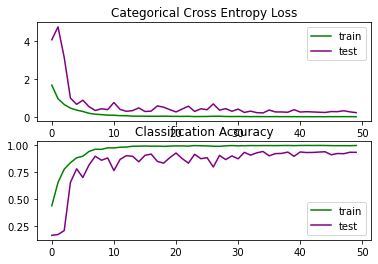

In [ ]:
evalmodel(cellfit7, cellmodel7,Xtest,ytest)

In [ ]:
#Saving model
cellmodel7.save('cellmodel7.h5')

### Employing Standard Image Augmentation for Better Training

In [ ]:
datagen = IDG()
iterator = datagen.flow(Xtrain, ytrain)

### Introducing Data Generator into Model

In [ ]:
cellmodel7 = tf.keras.models.load_model('cellmodel7.h5')

In [ ]:
cellmodel7.fit(iterator, steps_per_epoch = len(Xtrain)/512)

5/5 [==============================] - 7s 312ms/step - loss: 0.0384 - accuracy: 0.9896 - precision_8: 0.9896 - recall_8: 0.9896


## With Standard Image Data Augmentation + 5 Layers + Batch Normalization + Dropout

In [ ]:
_, acc,pre,re = cellmodel7.evaluate(Xtest, ytest, verbose=0)
print('The accuracy of the model is > %.3f' % (acc * 100.0))
predictions = cellmodel7.predict(Xtest)
y_test = np.argmax(ytest, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(crep(y_test,y_pred))

The accuracy of the model is > 79.762
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       152
           1       0.68      0.82      0.74       168
           2       0.90      0.97      0.93       152
           3       0.97      0.43      0.60       200
           4       0.95      0.62      0.75       184
           5       0.73      0.81      0.77       176
           6       0.88      0.99      0.93       176
           7       0.78      0.90      0.83       304

    accuracy                           0.80      1512
   macro avg       0.82      0.80      0.79      1512
weighted avg       0.82      0.80      0.79      1512



There is a slight bump in accuracy with standard image data augmentation.

In [ ]:
#Saving model
cellmodel7.save('cellmodel8.h5')

### Employing Horizontal Width Shift Image Augmentation for Better Training

In [ ]:
datagen2 = IDG(width_shift_range = [-50,50])
iterator2 = datagen2.flow(Xtrain, ytrain)

### Introducing Data Generator into Model

In [ ]:
cellmodel7_1 = tf.keras.models.load_model('cellmodel7.h5')

In [ ]:
cellmodel7_1.fit(iterator2, steps_per_epoch = len(Xtrain)/512)

5/5 [==============================] - 9s 310ms/step - loss: 1.3312 - accuracy: 0.6510 - precision_8: 0.6723 - recall_8: 0.6198


## With Horizontal Width Shift Image Data Augmentation + 5 Layers + Batch Normalization + Dropout

In [ ]:
_, acc,pre,re = cellmodel7_1.evaluate(Xtest, ytest, verbose=0)
print('The accuracy of the model is > %.3f' % (acc * 100.0))
predictions = cellmodel7_1.predict(Xtest)
y_test = np.argmax(ytest, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(crep(y_test,y_pred))

The accuracy of the model is > 70.304
              precision    recall  f1-score   support

           0       0.55      0.86      0.67       152
           1       0.53      0.71      0.61       168
           2       0.82      0.95      0.88       152
           3       0.99      0.48      0.65       200
           4       0.86      0.10      0.18       184
           5       0.72      0.65      0.69       176
           6       0.64      1.00      0.78       176
           7       0.83      0.87      0.85       304

    accuracy                           0.70      1512
   macro avg       0.74      0.70      0.66      1512
weighted avg       0.76      0.70      0.67      1512



There is a drastic drop in accuracy when using width shift.

### Employing Height Shift Image Augmentation for Better Training

In [ ]:
datagen3 = IDG(height_shift_range = 0.4)
iterator3 = datagen3.flow(Xtrain, ytrain)

### Introducing Data Generator into Model

In [ ]:
cellmodel8 = tf.keras.models.load_model('cellmodel8.h5')

In [ ]:
cellmodel8.fit(iterator3, steps_per_epoch = len(Xtrain)/512)

5/5 [==============================] - 7s 311ms/step - loss: 0.8870 - accuracy: 0.7656 - precision_8: 0.7637 - recall_8: 0.7240


## With Height Shift Image Data Augmentation + 5 Layers + Batch Normalization + Dropout

In [ ]:
_, acc,pre,re = cellmodel8.evaluate(Xtest, ytest, verbose=0)
print('The accuracy of the model is > %.3f' % (acc * 100.0))
predictions = cellmodel8.predict(Xtest)
y_test = np.argmax(ytest, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(crep(y_test,y_pred))

The accuracy of the model is > 76.587
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       152
           1       0.65      0.79      0.71       168
           2       0.92      0.94      0.93       152
           3       0.96      0.36      0.53       200
           4       0.88      0.66      0.76       184
           5       0.53      0.89      0.66       176
           6       0.90      0.99      0.94       176
           7       0.90      0.76      0.82       304

    accuracy                           0.77      1512
   macro avg       0.80      0.78      0.76      1512
weighted avg       0.81      0.77      0.76      1512



While this perofrms better than horizontal width shift, there is still a drop in overall accuracy, precision, recall and f-score metrics. 

### Employing Horizontal Flip Image Augmentation for Better Training

In [ ]:
datagen4 = IDG(horizontal_flip = True)
iterator4 = datagen4.flow(Xtrain, ytrain)

### Introducing Data Generator into Model

In [ ]:
cellmodel9 = tf.keras.models.load_model('cellmodel8.h5')

In [ ]:
cellmodel9.fit(iterator4, steps_per_epoch = len(Xtrain)/512)

5/5 [==============================] - 7s 312ms/step - loss: 0.5052 - accuracy: 0.8802 - precision_8: 0.8984 - recall_8: 0.8750


## With Horizontal Flip Image Data Augmentation + 5 Layers + Batch Normalization + Dropout

In [ ]:
_, acc,pre,re = cellmodel9.evaluate(Xtest, ytest, verbose=0)
print('The accuracy of the model is > %.3f' % (acc * 100.0))
predictions = cellmodel9.predict(Xtest)
y_test = np.argmax(ytest, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(crep(y_test,y_pred))

The accuracy of the model is > 76.587
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       152
           1       0.63      0.79      0.70       168
           2       0.85      0.98      0.91       152
           3       0.97      0.36      0.53       200
           4       0.99      0.47      0.63       184
           5       0.60      0.88      0.71       176
           6       0.85      0.99      0.92       176
           7       0.83      0.87      0.85       304

    accuracy                           0.77      1512
   macro avg       0.80      0.77      0.75      1512
weighted avg       0.81      0.77      0.75      1512



Similar results to shifting augmentation. 

### Employing Vertical Flip Image Augmentation for Better Training

In [ ]:
datagen5 = IDG(vertical_flip = True)
iterator5 = datagen5.flow(Xtrain, ytrain)

### Introducing Data Generator into Model

In [ ]:
cellmodel10 = tf.keras.models.load_model('cellmodel8.h5')

In [ ]:
cellmodel10.fit(iterator5, steps_per_epoch = len(Xtrain)/512)

5/5 [==============================] - 7s 313ms/step - loss: 0.3828 - accuracy: 0.8906 - precision_8: 0.8984 - recall_8: 0.8750


## With Vertical Flip Image Data Augmentation + 5 Layers + Batch Normalization + Dropout

In [ ]:
_, acc,pre,re = cellmodel10.evaluate(Xtest, ytest, verbose=0)
print('The accuracy of the model is > %.3f' % (acc * 100.0))
predictions = cellmodel10.predict(Xtest)
y_test = np.argmax(ytest, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(crep(y_test,y_pred))

The accuracy of the model is > 78.108
              precision    recall  f1-score   support

           0       0.66      0.80      0.73       152
           1       0.76      0.77      0.77       168
           2       0.87      0.97      0.92       152
           3       0.94      0.34      0.49       200
           4       0.93      0.68      0.78       184
           5       0.67      0.72      0.69       176
           6       0.93      0.99      0.96       176
           7       0.71      0.96      0.82       304

    accuracy                           0.78      1512
   macro avg       0.81      0.78      0.77      1512
weighted avg       0.81      0.78      0.77      1512



Better performance than horizontal/vertical width shift augmentation and horizontal flip augmentation. However, still lower than our most accomplished model. 

### Employing Random Rotation Image Augmentation for Better Training

In [ ]:
datagen6 = IDG(rotation_range=90)
iterator6 = datagen6.flow(Xtrain, ytrain) 

### Introducing Data Generator into Model

In [ ]:
cellmodel11 = tf.keras.models.load_model('cellmodel8.h5')

In [ ]:
cellmodel11.fit(iterator6, steps_per_epoch = len(Xtrain)/512)

5/5 [==============================] - 7s 313ms/step - loss: 1.0431 - accuracy: 0.7240 - precision_8: 0.7556 - recall_8: 0.7083


## With Random Rotation Image Data Augmentation + 5 Layers + Batch Normalization + Dropout

In [ ]:
_, acc,pre,re = cellmodel11.evaluate(Xtest, ytest, verbose=0)
print('The accuracy of the model is > %.3f' % (acc * 100.0))
predictions = cellmodel11.predict(Xtest)
y_test = np.argmax(ytest, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(crep(y_test,y_pred))

The accuracy of the model is > 72.156
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       152
           1       0.93      0.61      0.74       168
           2       0.88      0.94      0.91       152
           3       0.78      0.21      0.33       200
           4       0.84      0.90      0.87       184
           5       0.62      0.40      0.49       176
           6       0.87      0.93      0.90       176
           7       0.57      0.96      0.72       304

    accuracy                           0.72      1512
   macro avg       0.76      0.71      0.70      1512
weighted avg       0.75      0.72      0.70      1512



Reduction in performance.

### Employing Random Brightness Image Augmentation for Better Training

In [ ]:
datagen7 = IDG(brightness_range=[0.2,1.0])
iterator7 = datagen7.flow(Xtrain, ytrain) 

### Introducing Data Generator into Model

In [ ]:
cellmodel12 = tf.keras.models.load_model('cellmodel8.h5')

In [ ]:
cellmodel12.fit(iterator7, steps_per_epoch = len(Xtrain)/512)

5/5 [==============================] - 7s 310ms/step - loss: 4.5772 - accuracy: 0.2865 - precision_8: 0.3121 - recall_8: 0.2812


## With Random Brightness Image Data Augmentation + 5 Layers + Batch Normalization + Dropout

In [ ]:
_, acc,pre,re = cellmodel12.evaluate(Xtest, ytest, verbose=0)
print('The accuracy of the model is > %.3f' % (acc * 100.0))
predictions = cellmodel12.predict(Xtest)
y_test = np.argmax(ytest, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(crep(y_test,y_pred))

The accuracy of the model is > 9.392
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       152
           1       0.00      0.00      0.00       168
           2       0.07      0.60      0.13       152
           3       0.00      0.00      0.00       200
           4       0.00      0.00      0.00       184
           5       0.19      0.29      0.23       176
           6       0.00      0.00      0.00       176
           7       0.00      0.00      0.00       304

    accuracy                           0.09      1512
   macro avg       0.03      0.11      0.04      1512
weighted avg       0.03      0.09      0.04      1512



C:\Users\Yousuf\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Yousuf\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Yousuf\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



This is the worst model. 

### Employing Random Zoom Image Augmentation for Better Training

In [ ]:
datagen8 = IDG(zoom_range=[0.5,1.0]) 
iterator8 = datagen8.flow(Xtrain, ytrain)

### Introducing Data Generator into Model

In [ ]:
cellmodel13 = tf.keras.models.load_model('cellmodel8.h5')

In [ ]:
cellmodel13.fit(iterator8, steps_per_epoch = len(Xtrain)/512)

5/5 [==============================] - 7s 311ms/step - loss: 1.6513 - accuracy: 0.5781 - precision_8: 0.6044 - recall_8: 0.5729


## With Random Zoom Image Data Augmentation + 5 Layers + Batch Normalization + Dropout

In [ ]:
_, acc,pre,re = cellmodel13.evaluate(Xtest, ytest, verbose=0)
print('The accuracy of the model is > %.3f' % (acc * 100.0))
predictions = cellmodel13.predict(Xtest)
y_test = np.argmax(ytest, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(crep(y_test,y_pred))

The accuracy of the model is > 61.772
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       152
           1       0.65      0.75      0.70       168
           2       0.40      0.99      0.57       152
           3       0.49      0.11      0.18       200
           4       0.77      0.39      0.51       184
           5       0.50      0.74      0.60       176
           6       0.66      0.33      0.44       176
           7       0.84      0.91      0.87       304

    accuracy                           0.62      1512
   macro avg       0.64      0.61      0.57      1512
weighted avg       0.65      0.62      0.59      1512



## Log Transforming Data to Improve Feature Recognition.

In [ ]:
logXtrain = []
for i in range(len(Xtrain)):
    logXtrain.append(np.log(Xtrain[i])+1)
logytrain = []
for i in range(len(ytrain)):
    logytrain.append(np.log(ytrain[i])+1)
logXval = []
for i in range(len(Xval)):
    logXval.append(np.log(Xval[i])+1)
logyval = []
for i in range(len(yval)):
    logyval.append(np.log(yval[i])+1)
logXtest = []
for i in range(len(Xtest)):
    logXtest.append(np.log(Xtest[i])+1)
logytest = []
for i in range(len(ytest)):
    logytest.append(np.log(ytest[i])+1)

C:\Users\Yousuf\AppData\Local\Temp/ipykernel_9244/1020713656.py:6: RuntimeWarning:

divide by zero encountered in log

C:\Users\Yousuf\AppData\Local\Temp/ipykernel_9244/1020713656.py:12: RuntimeWarning:

divide by zero encountered in log

C:\Users\Yousuf\AppData\Local\Temp/ipykernel_9244/1020713656.py:18: RuntimeWarning:

divide by zero encountered in log



Log transforming data results in dividing by zero which corrupts the data and doesn't bode well for analysis. Scrapping this transformation. 

## Power Transforming Data to Improve Feature Recognition.

In [ ]:
powerXtrain = []
for i in range(len(Xtrain)):
    powerXtrain.append(Xtrain[i]**2)
powerytrain = []
for i in range(len(ytrain)):
    powerytrain.append(ytrain[i]**2)
powerXval = []
for i in range(len(Xval)):
    powerXval.append(Xval[i]**2)
poweryval = []
for i in range(len(yval)):
    poweryval.append(yval[i]**2)
powerXtest = []
for i in range(len(Xtest)):
    powerXtest.append(Xtest[i]**2)
powerytest = []
for i in range(len(ytest)):
    powerytest.append(ytest[i]**2)

In [ ]:
#Transforming X datasets in to arrays
powerXtrain=np.array(powerXtrain)
powerXval = np.array(powerXval)
powerXtest = np.array(powerXtest)
powerytrain = np.array(powerytrain)
poweryval = np.array(poweryval)
powerytest = np.array(powerytest)

In [ ]:
#Saving power transformed training and testing sets
pickle_out = open("powerXtrain.pickle", "wb")
pickle.dump(powerXtrain, pickle_out)
pickle_out.close()

pickle_out = open("powerXval.pickle", "wb")
pickle.dump(powerXval, pickle_out)
pickle_out.close()

pickle_out = open("powerXtest.pickle", "wb")
pickle.dump(powerXtest, pickle_out)
pickle_out.close()

pickle_out = open("powerytrain.pickle", "wb")
pickle.dump(powerytrain, pickle_out)
pickle_out.close()

pickle_out = open("poweryval.pickle", "wb")
pickle.dump(poweryval, pickle_out)
pickle_out.close()

pickle_out = open("powerytest.pickle", "wb")
pickle.dump(powerytest, pickle_out)
pickle_out.close()

In [ ]:
#Importing power transformed training and testing sets
pickle_in = open("powerXtrain.pickle","rb")
powerXtrain = pickle.load(pickle_in)

pickle_in = open("powerXval.pickle","rb")
powerXval = pickle.load(pickle_in)

pickle_in = open("powerXtest.pickle","rb")
powerXtest = pickle.load(pickle_in)

pickle_in = open("powerytrain.pickle","rb")
powerytrain = pickle.load(pickle_in)

pickle_in = open("poweryval.pickle","rb")
poweryval = pickle.load(pickle_in)

pickle_in = open("powerytest.pickle","rb")
powerytest = pickle.load(pickle_in)

### Using Power Transformed data on Best Model Configuration

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
cellmodel14 = define_model7(input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 512)     5120      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 512)    2048      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 256)       1179904   
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
earlystopper = EarlyStopping(patience=25, verbose=1)
checkpoint = ModelCheckpoint('earlystoppingmodel.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

cellfit14 = cellmodel14.fit(powerXtrain, powerytrain, epochs = 50, batch_size = 16, validation_data = (powerXval, poweryval), callbacks=callbacks_list)

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 1.6411 - accuracy: 0.4463 - precision: 0.5491 - recall: 0.3240
Epoch 00001: val_loss improved from inf to 5.04697, saving model to earlystoppingmodel.h5
163/163 [==============================] - 30s 152ms/step - loss: 1.6411 - accuracy: 0.4463 - precision: 0.5491 - recall: 0.3240 - val_loss: 5.0470 - val_accuracy: 0.1028 - val_precision: 0.1413 - val_recall: 0.1028
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 0.9275 - accuracy: 0.6672 - precision: 0.7609 - recall: 0.5625
Epoch 00002: val_loss did not improve from 5.04697
163/163 [==============================] - 23s 141ms/step - loss: 0.9275 - accuracy: 0.6672 - precision: 0.7609 - recall: 0.5625 - val_loss: 6.0479 - val_accuracy: 0.0840 - val_precision: 0.0853 - val_recall: 0.0840
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 0.6507 - accuracy: 0.7715 - precision: 0.8320 - recall: 0.6967
Epoch 00003: val_loss improv

Epoch 21/50
163/163 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9889 - precision: 0.9892 - recall: 0.9862
Epoch 00021: val_loss did not improve from 0.26383
163/163 [==============================] - 24s 149ms/step - loss: 0.0407 - accuracy: 0.9889 - precision: 0.9892 - recall: 0.9862 - val_loss: 0.4075 - val_accuracy: 0.8651 - val_precision: 0.8824 - val_recall: 0.8579
Epoch 22/50
163/163 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9885 - precision: 0.9892 - recall: 0.9873
Epoch 00022: val_loss did not improve from 0.26383
163/163 [==============================] - 24s 148ms/step - loss: 0.0371 - accuracy: 0.9885 - precision: 0.9892 - recall: 0.9873 - val_loss: 0.3831 - val_accuracy: 0.8785 - val_precision: 0.8969 - val_recall: 0.8704
Epoch 23/50
163/163 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9942 - precision: 0.9950 - recall: 0.9935
Epoch 00023: val_loss did not improve from 0.26383
163/163 [====

163/163 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9969
Epoch 00041: val_loss did not improve from 0.22661
163/163 [==============================] - 24s 150ms/step - loss: 0.0112 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9969 - val_loss: 0.3284 - val_accuracy: 0.9008 - val_precision: 0.9100 - val_recall: 0.8945
Epoch 42/50
163/163 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9988 - precision: 0.9992 - recall: 0.9988
Epoch 00042: val_loss improved from 0.22661 to 0.21492, saving model to earlystoppingmodel.h5
163/163 [==============================] - 24s 150ms/step - loss: 0.0094 - accuracy: 0.9988 - precision: 0.9992 - recall: 0.9988 - val_loss: 0.2149 - val_accuracy: 0.9366 - val_precision: 0.9429 - val_recall: 0.9294
Epoch 43/50
163/163 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965
Epoch 00043: val_loss improved fr

The accuracy of the model is > 80.159
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       152
           1       0.84      0.77      0.80       168
           2       0.88      0.97      0.93       152
           3       0.85      0.38      0.53       200
           4       0.92      0.74      0.82       184
           5       0.69      0.84      0.76       176
           6       0.94      1.00      0.97       176
           7       0.73      0.92      0.81       304

    accuracy                           0.80      1512
   macro avg       0.82      0.80      0.79      1512
weighted avg       0.81      0.80      0.79      1512



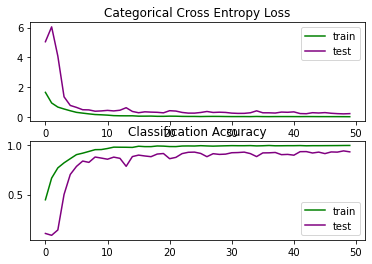

In [ ]:
evalmodel(cellfit14, cellmodel14,powerXtest,powerytest)

We have achieved a marginally better classification performance with power transformed data.  

In [ ]:
#Saving model
cellmodel14.save('cellmodel14.h5')

In [ ]:
#Loading model
cellmodel14 = tf.keras.models.load_model('cellmodel14.h5')

In [ ]:
datagen10 = IDG()
iterator10= datagen10.flow(powerXtrain, powerytrain)

### Introducing Data Generator into Model

In [ ]:
cellmodel14.fit(iterator10, steps_per_epoch = len(powerXtrain)/512)

5/5 [==============================] - 7s 310ms/step - loss: 8.8338e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


## With Horizontal Width Shift Image Data Augmentation + 5 Layers + Batch Normalization + Dropout

In [ ]:
_, acc,pre,re = cellmodel14.evaluate(powerXtest, powerytest, verbose=0)
print('The accuracy of the model is > %.3f' % (acc * 100.0))
predictions = cellmodel14.predict(powerXtest)
y_test = np.argmax(powerytest, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(crep(y_test,y_pred))

The accuracy of the model is > 80.622
              precision    recall  f1-score   support

           0       0.71      0.80      0.76       152
           1       0.84      0.77      0.80       168
           2       0.88      0.97      0.93       152
           3       0.85      0.39      0.53       200
           4       0.92      0.75      0.83       184
           5       0.71      0.84      0.77       176
           6       0.94      1.00      0.97       176
           7       0.73      0.92      0.82       304

    accuracy                           0.81      1512
   macro avg       0.82      0.81      0.80      1512
weighted avg       0.82      0.81      0.80      1512



Classification performance has improved marginally after standard image augmentation. This is undoubtedly the best model we have tested.  

In [ ]:
#Saving model
cellmodel14.save('bestcellmodelfinal.h5')

The performance of the custom CNN for image classification is outrightly better than the U-NET model for image segmentation.

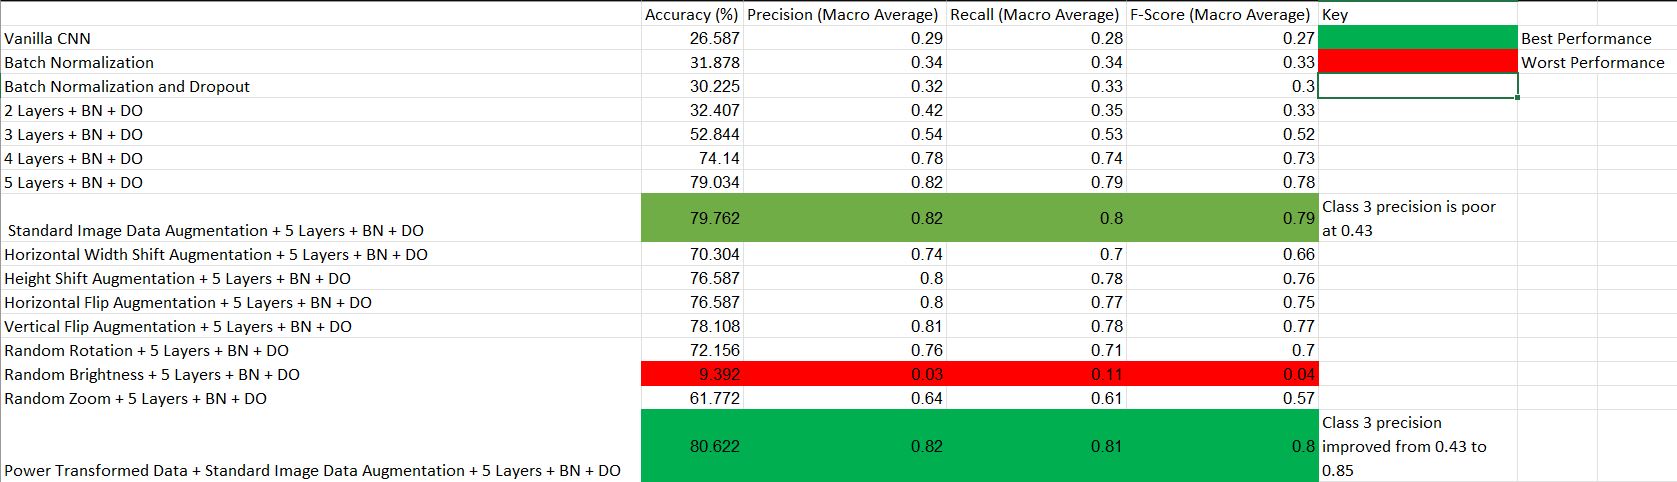